<a href="https://colab.research.google.com/github/frolovtsev/FGI/blob/main/fiber_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip install pymmf
clear_output()

## Классы для задания параметров

In [2]:
import numpy as np
import json

class FiberParams:
    def __init__(self, NA=0.20, radius=25., wavelength=1.55, fiber_type='GRIN', n_center=1.45,
                 area_size=2.4*25, n_pixels_x=128):
        self.NA = NA
        self.radius = radius
        self.wavelength = wavelength
        self.fiber_type = fiber_type
        self.n_center = n_center

        self.area_size = area_size
        self.n_pixels_x = n_pixels_x

    def save_params(self, filename, mode='w', openfile=True):
        if openfile:
            with open(filename, mode=mode) as fp:
                json.dump(self.__dict__, fp, indent=4)
        else:
            json.dump(self.__dict__, filename, indent=4)

    def load_params(self, fp):
        self.__dict__ = json.load(fp)


class ModeSolverParams:
    def __init__(self, change_bc_radius_step=0.95, N_beta_coarse=1000,
                 degenerate_mode='exp', min_radius_bc=1.5,
                 r_max=3.2*25, n_points_search=2**8, dh=2*25/(2**8)):
        self.change_bc_radius_step = change_bc_radius_step
        self.N_beta_coarse = 1000
        self.degenerate_mode = degenerate_mode
        self.min_radius_bc = min_radius_bc
        self.r_max = r_max
        self.n_points_search = n_points_search
        self.dh = dh

    def save_params(self, filename, mode='w', openfile=True):
        if openfile:
            with open(filename, mode=mode) as fp:
                json.dump(self.__dict__, fp, indent=4)
        else:
            json.dump(self.__dict__, filename, indent=4)

    def load_params(self, fp):
        self.__dict__ = json.load(fp)

## Класс-обертка pyMMF для расчета собственных мод волокна

In [3]:
import pyMMF

class ComplexModeSolver:
    def __init__(self, fiber_params_obj, solver_params_obj):
        self.fiber_params = fiber_params_obj
        self.solver_params = solver_params_obj

        self.profile = pyMMF.IndexProfile(npoints=self.fiber_params.n_pixels_x,
                                          areaSize=self.fiber_params.area_size)
        self.profile.initParabolicGRIN(n1=self.fiber_params.n_center,
                                       a=self.fiber_params.radius,
                                       NA=self.fiber_params.NA)
        self.solver = pyMMF.propagationModeSolver()
        self.solver.setIndexProfile(self.profile)
        self.solver.setWL(self.fiber_params.wavelength)

    def solve(self):
        modes = self.solver.solve(mode='radial',
                                  curvature=None,
                                  r_max=self.solver_params.r_max,
                                  dh=self.solver_params.dh,
                                  min_radius_bc=self.solver_params.min_radius_bc,
                                  change_bc_radius_step=self.solver_params.change_bc_radius_step,
                                  N_beta_coarse=self.solver_params.N_beta_coarse,
                                  degenerate_mode=self.solver_params.degenerate_mode)
        clear_output()
        return modes

In [4]:
fiber_params = FiberParams()
solver_params = ModeSolverParams()
solver = ComplexModeSolver(fiber_params, solver_params)

modes = solver.solve()

In [5]:
solver_params.save_params('solver.json')
fiber_params.save_params('fiber.json')

## Нахождение комбинаций собственых мод волокна

In [6]:
from itertools import combinations
from copy import deepcopy

class ModesIntensityObtainer:
    '''
    returns list with intensity profiles, as well as list with periodicities,
    i.e. periodicity=2 means that rotation 2pi/2 gives the original result.
    for centrosymmetric profiles, periodicity=1
    '''
    def __init__(self, modes, kind='linearly_independent_all', tol=0.001):
        self.modes = modes
        self.tol = tol
        groups_of_neardeg_modes = np.array(self.modes.getNearDegenerate(tol=self.tol))
        l = np.array(self.modes.l)
        m = np.array(self.modes.m)

        self.amplitude_profiles = modes.getModeMatrix()
        self.size = int(np.sqrt( len(self.amplitude_profiles[:,0])  ))

        self.intensity_profiles = []
        self.modes_info = []

        if kind=='linearly_independent_all':
            for group in groups_of_neardeg_modes:
                # for each mode with the same propagation constant
                # we add its intensity and the result of interference of all pairs of modes
                # with phases difference of 0 and pi/2
                m_group = m[group]
                l_group = l[group]

                # start with modes without interference:
                for mode_idx in group:
                    intens_prof = (np.abs(self.amplitude_profiles[:,mode_idx])**2).reshape((self.size, self.size))
                    self.intensity_profiles.append(intens_prof)

                    mode_dict_curr = {}
                    mode_dict_curr['l'] = self.modes.l[mode_idx]
                    mode_dict_curr['m'] = self.modes.m[mode_idx]
                    mode_dict_curr['beta'] = self.modes.betas[mode_idx]
                    mode_dict_curr['phase'] = 0.
                    mode_dict_curr['mode_idx'] = mode_idx
                    self.modes_info.append([mode_dict_curr])

                # and add combinations of all modes with phases 0 and pi/2

                for (mode_idx1, mode_idx2) in combinations(group, 2):
                    intens_prof1 = ( np.abs(
                        self.amplitude_profiles[:,mode_idx1] + self.amplitude_profiles[:,mode_idx2])**2).reshape((self.size, self.size))
                    intens_prof2 = ( np.abs(
                        self.amplitude_profiles[:,mode_idx1] + 1j*self.amplitude_profiles[:,mode_idx2])**2).reshape((self.size, self.size))

                    self.intensity_profiles.append(intens_prof1)
                    self.intensity_profiles.append(intens_prof2)
                    mode1_info = {}
                    mode2_info = {}
                    mode1_info['l'] = self.modes.l[mode_idx1]
                    mode1_info['m'] = self.modes.m[mode_idx1]
                    mode1_info['beta'] = self.modes.betas[mode_idx1]
                    mode1_info['phase'] = 0.
                    mode1_info['mode_idx'] = mode_idx1

                    mode2_info['l'] = self.modes.l[mode_idx2]
                    mode2_info['m'] = self.modes.m[mode_idx2]
                    mode2_info['beta'] = self.modes.betas[mode_idx2]
                    mode2_info['phase'] = 0
                    mode2_info['mode_idx'] = mode_idx2

                    self.modes_info.append([mode1_info, deepcopy(mode2_info)])
                    mode2_info['phase'] = np.pi/2
                    self.modes_info.append([mode1_info, mode2_info])
            
    def getIntensityProfiles(self):
        return self.intensity_profiles

    def getModesInfo(self):
        # returns list with information about modes
        # returns list [list of interfering modes of {dict 'n' : int, 'l': int, 'phase': int ... } ]
        return self.modes_info



In [7]:
intensities = ModesIntensityObtainer(modes)

<ipython-input-6-43e22196f1c6>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  groups_of_neardeg_modes = np.array(self.modes.getNearDegenerate(tol=self.tol))


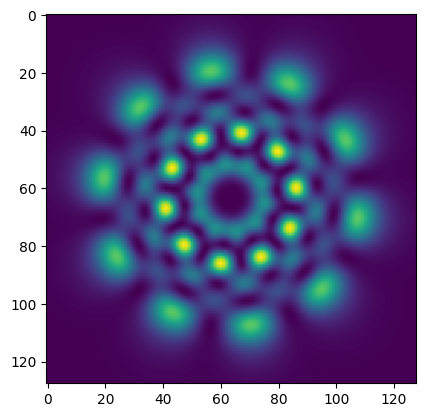

In [8]:
import matplotlib.pyplot as plt

plt.imshow(intensities.getIntensityProfiles()[350])

## Блок кода для создания датасета с постоянно изогнутым волокном

---



In [9]:
from torchvision import  transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch
import random
import torch.nn as nn

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: ', device)

using device:  cuda


In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float32),
     nn.Flatten()
     ])

mnist = datasets.MNIST('MNIST', train=True, download=True, transform=transform) # 60 000
mnist_test = datasets.MNIST('MNIST', train=False, download=True, transform=transform) # 10 000

#train_set, val_set , _ = random_split(mnist, [16000, 4000, 40000])

#train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
#val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)

clear_output()

Create dataset from obtained data

In [11]:
from torch.utils.data import Dataset


class SimpleFGI_MNIST(Dataset):
    def __init__(self, mnist_dataset, patterns, fgi_vec_transform=None, 
                 target_img_transform=None, task="classification"):
        super().__init__()

        self.img_size = len(mnist_dataset.data[0])
        mnist_images = mnist_dataset.data

        mnist_transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                              transforms.Normalize(0, 0.5),
                                              nn.Flatten()])
        patterns_transform = transforms.Compose([transforms.Resize(self.img_size),
                                            transforms.ConvertImageDtype(torch.float32),
                                            transforms.Normalize(0, 0.5),
                                            nn.Flatten()])
        self.target_labels = mnist_dataset.targets
        self.patterns = patterns_transform(patterns)
        self.target_images = mnist_transform(mnist_images)
        self.fgi_vectors = torch.matmul(self.target_images, self.patterns.T)
        
        if fgi_vec_transform is not None:
            self.fgi_vectors = fgi_vec_transform(self.fgi_vectors)

        if target_img_transform is not None:
            self.target_images = target_img_transform(self.target_images)

        if task=='classification':
            self.y = self.target_labels
        elif task=='image_restoration':
            self.y = self.target_images
        else:
            raise TypeError("Can't create dataset because the type of task is invalid")


    def __len__(self):
        return len(self.target_labels)

    def __getitem__(self, idx):
        return self.fgi_vectors[idx], self.y[idx]


In [12]:
fgi_test_dataset = SimpleFGI_MNIST(mnist_test, 
                                   torch.Tensor(intensities.getIntensityProfiles()),
                                   task='classification')

fgi_train_dataset = SimpleFGI_MNIST(mnist, 
                                   torch.Tensor(intensities.getIntensityProfiles()),
                                   task='classification')

<ipython-input-12-80013dde0777>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  torch.Tensor(intensities.getIntensityProfiles()),
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the ca

In [13]:
train_loader = DataLoader(fgi_train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(fgi_test_dataset, batch_size=256, shuffle=False, num_workers=2)

## Тестовая модель, состоящая из 4-х полносвязных слоев

In [14]:
class SimpleFGIClassifier(nn.Module):
    def __init__(self, num_patterns):
        super().__init__()

        self.net = nn.Sequential( nn.Linear(num_patterns, 128),
                                 nn.BatchNorm1d(128),
                                 nn.ReLU(),
                                 nn.Linear(128, 256),
                                 nn.BatchNorm1d(256),
                                 nn.ReLU(),
                                 nn.Linear(256, 128),
                                 nn.BatchNorm1d(128),
                                 nn.ReLU(),
                                 nn.Linear(128, 10),
                                 nn.Softmax() )
    def forward(self, x):
        return self.net(x)

In [15]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calaculate_accuracy(model, data_loader, criterion, device):
    correct, total = 0, 0 
    loss = 0 
    for batch in data_loader:
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        pred = model(imgs)
        loss += criterion(pred, labels)
        correct += get_correct_count(pred,labels)
        total += labels.size(0)
        
    return correct / total , loss.item() / len(data_loader)

## Блок кода для обучения модели

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt

class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="best")
        if history_len < 20:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(24 // n_groups, 5))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [17]:
def train(model, criterion, optimizer, num_epochs=10, tag="cifar10", device='cpu', pp=None):
    if pp is None:
        pp = ProgressPlotter(groups=['loss', 'accuracy'])
    for epoch in range(num_epochs):
        correct, total, ep_loss = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)     
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            correct += get_correct_count(outputs,labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            ep_loss += loss.item()
        # Logging
        pp.add_scalar('loss', ep_loss / len(train_loader), 'train')
        pp.add_scalar('accuracy', correct/total, 'train')

        accuracy, loss_val = calaculate_accuracy(model,test_loader,criterion, device)
        pp.add_scalar('loss',loss_val, 'test')
        pp.add_scalar('accuracy',accuracy, 'test')

        pp.display()
    return pp

## Тестирование модели на паттернах на входе в волокно

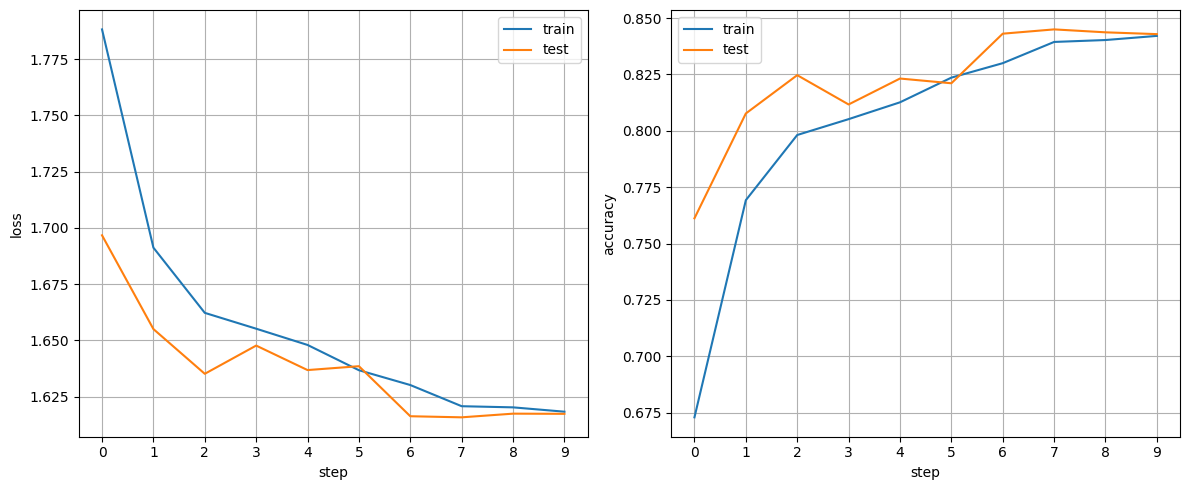

In [18]:
set_random_seed(42)
model = SimpleFGIClassifier(len(intensities.getIntensityProfiles())).to(device)  # Create model instance
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model, criterion, optimizer, num_epochs=10, device=device)

## Класс Bender для нахождения паттернов на дальнем конце изогнутого или прямого (радиус кривизны -- $\infty$) волокна

In [19]:
class Bender:
    '''
    Bender computes intensity patterns of curved fibers
    '''
    def __init__(self, modes : ComplexModeSolver,
                 curvature_mkm,
                 distance_mkm):
        self.modes = modes
        self.curvature = curvature_mkm
        self.distance = distance_mkm
        self.propagation_matrix = self.modes.getPropagationMatrix(
                                            curvature=self.curvature,
                                            distance=self.distance)
        self.length = self.propagation_matrix.shape[0]
        self.curved_modes_matrix = self.modes.getModeMatrix().dot(self.propagation_matrix)
        self.img_size = int( np.sqrt(modes.getModeMatrix().shape[0]) )

    def _get_mode_vector(self, modes_info_list):
        vector = np.zeros(self.length, dtype=np.complex128)
        for info_dict in modes_info_list:
            vector[info_dict['mode_idx']] = np.exp(1j*info_dict['phase'])
        return vector/np.sqrt(self.length)

    def getCurvedAmplitudes_one_mode(self, modes_info_list):
        modes_vector = self._get_mode_vector(modes_info_list)
        amplitude = self.curved_modes_matrix.dot(modes_vector)
        return amplitude

    def getIntensityProfilesCurved(self, modes_info):
        #intensities = np.zeros((self.modes.getModeMatrix().shape[0], len(modes_info)),
        #                       dtype=np.float64)
        intensities = []
        for modes_info_list in modes_info:
            amplitude = self.getCurvedAmplitudes_one_mode(modes_info_list)
            intensities.append((np.abs(amplitude)**2).reshape(
                                            (self.img_size, self.img_size)) )
        return intensities

## Датасет, даталоадер и обучение модели на модах прямого волокна

Создадим датасет с модами на конце прямого волокна (выше был пример с модами на входе, т.к. эффект распространения не был принят во вниммание. Моды были собраны на группы почти вырожденных, при прохождении волокна из-за небольшой растройки констант распространения набегает фаза, интерферирующие моды немного "поворачиваются"). Радиусы кривизны равны бесконечности, а длина волокна -- 300 мм (все размеры в коде -- в микронах)

In [20]:
bender_direct = Bender(modes, [np.inf, np.inf], 300.0e3)

In [21]:
intensities_direct = bender_direct.getIntensityProfilesCurved(intensities.getModesInfo())

In [22]:
fgi_test_dataset = SimpleFGI_MNIST(mnist_test, 
                                   torch.Tensor(intensities_direct),
                                   task='classification')

fgi_train_dataset = SimpleFGI_MNIST(mnist, 
                                   torch.Tensor(intensities_direct),
                                   task='classification')

train_loader = DataLoader(fgi_train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(fgi_test_dataset, batch_size=256, shuffle=False, num_workers=2)

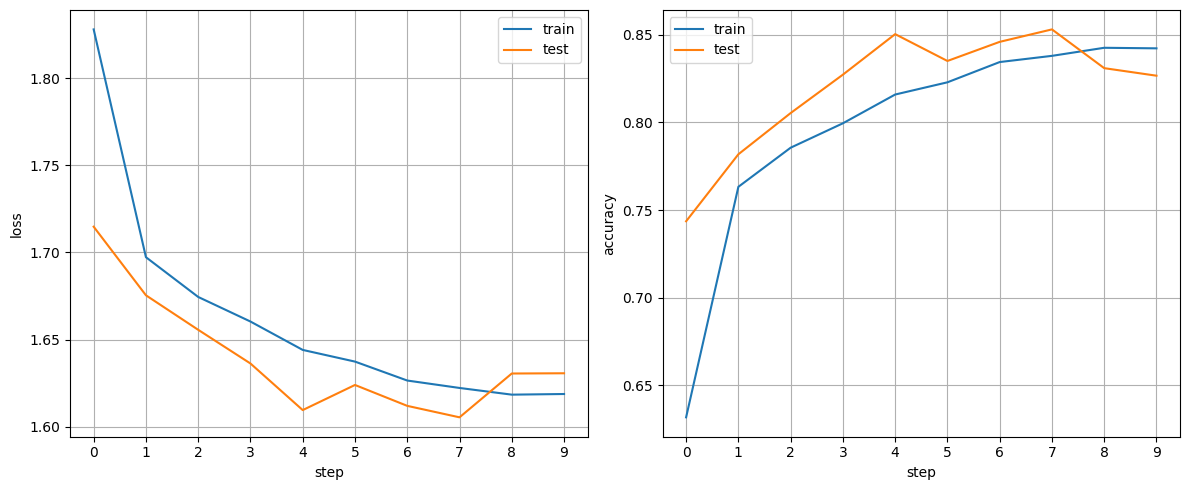

In [23]:
set_random_seed(42)
model = SimpleFGIClassifier(len(intensities.getIntensityProfiles())).to(device)  # Create model instance
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model, criterion, optimizer, num_epochs=10, device=device)

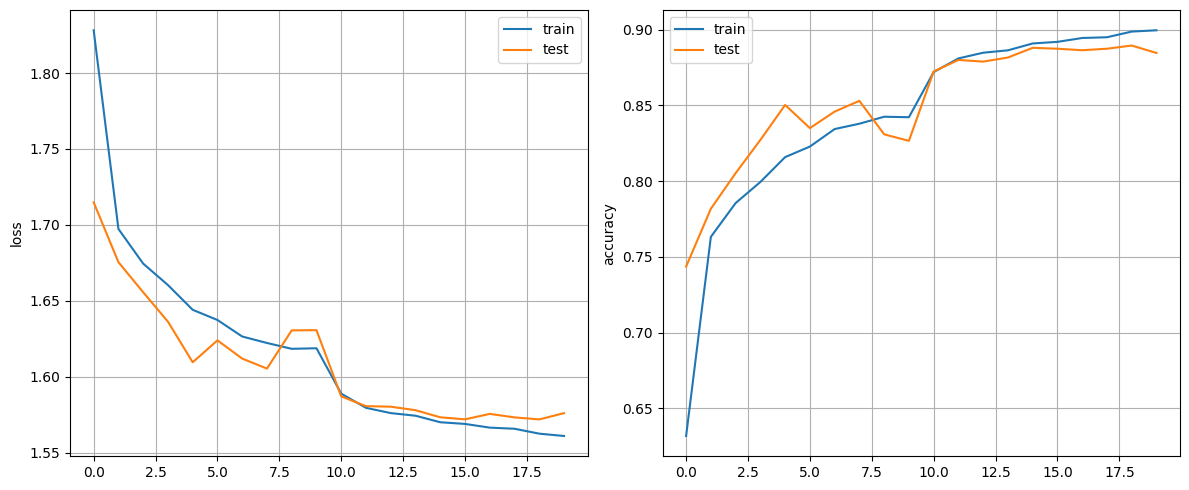

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model, criterion, optimizer, num_epochs=10, device=device, pp=pp)

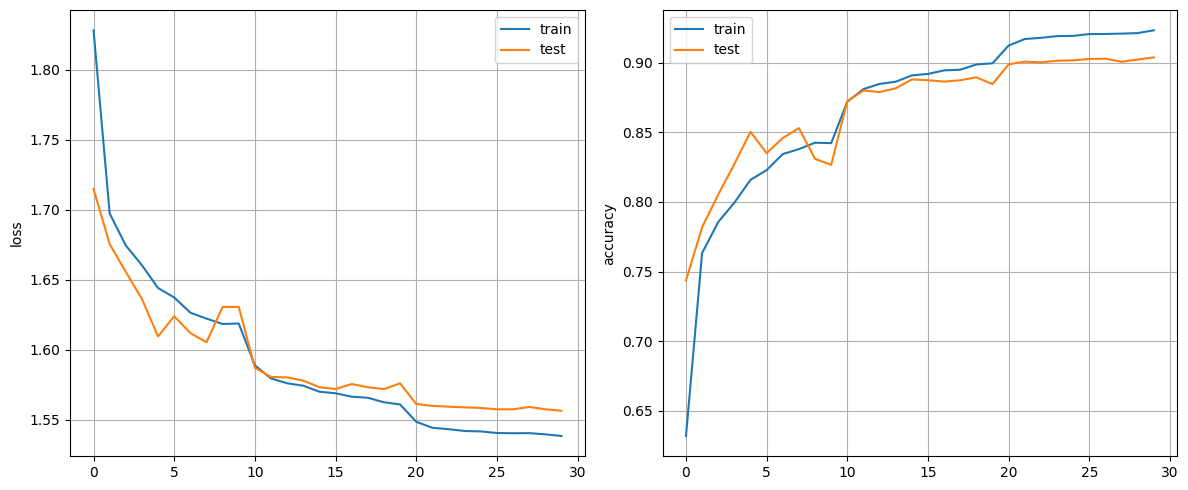

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
pp = train(model, criterion, optimizer, num_epochs=10, device=device, pp=pp)

## Создание дополнительных датасетов и тестирование предсказаний модели, обченной на прямом волокне по данным для изогнутого волокна

In [26]:
cm = 1.0e4 # 1 cm in microns
curvatures = [np.inf, 100*cm, 30*cm, 10*cm, 5*cm, 3*cm]

# curved fiber along x-axis
accuracies_curved_x = []
for radius in curvatures:
    bender_curved = Bender(modes, [radius, np.inf], 300.0e3)
    intensities_curved = bender_curved.getIntensityProfilesCurved(intensities.getModesInfo())
    fgi_test_dataset_curved = SimpleFGI_MNIST(mnist_test, 
                                   torch.Tensor(intensities_curved),
                                   task='classification')
    test_loader_curved = DataLoader(fgi_test_dataset_curved, batch_size=256, shuffle=False, num_workers=2)
    accuracies_curved_x.append(calaculate_accuracy(model, test_loader_curved, criterion, device)[0])

In [27]:
accuracy = np.array(accuracies_curved_x)
curvatures_arr = np.array(curvatures)

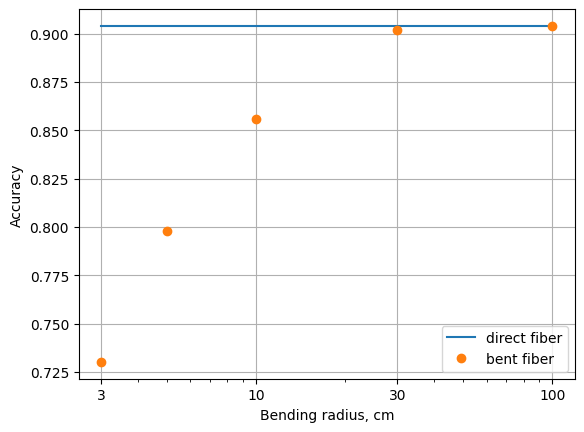

In [28]:

import matplotlib.pyplot as plt

horiz_line = [accuracy[0]] * (len(accuracy)-1)

plt.xscale('log')
plt.grid()
plt.xlabel('Bending radius, cm')
plt.ylabel('Accuracy')
plt.xticks([3, 10, 30, 100], [3, 10, 30, 100])

plt.plot(curvatures_arr[1:]/cm, horiz_line, label='direct fiber')
plt.plot(curvatures_arr[1:]/cm, accuracy[1:], 'o', label='bent fiber')
plt.legend()
plt.savefig('model_direct_fiber_bent')
plt.show()

## Давайте посмотрим, как страдают паттерны от изгиба волокна

Здесь картинки с тем, как искривляются различные моды.
Выбраны 10 различных мод (разные строки) и для них при различных радиусах кривизны (разные столбцы) показаны моды

In [29]:
set_random_seed(41)
modes_numbers = np.sort( np.random.randint(0, 385, 10) )
print(modes_numbers)

[ 80  89 131 163 178 236 243 282 321 365]


In [30]:
total_curved_intensities = []
for radius in curvatures:
    bender_curved = Bender(modes, [radius, np.inf], 300.0e3)
    intensities_curved = bender_curved.getIntensityProfilesCurved(intensities.getModesInfo())
    total_curved_intensities.append(intensities_curved)

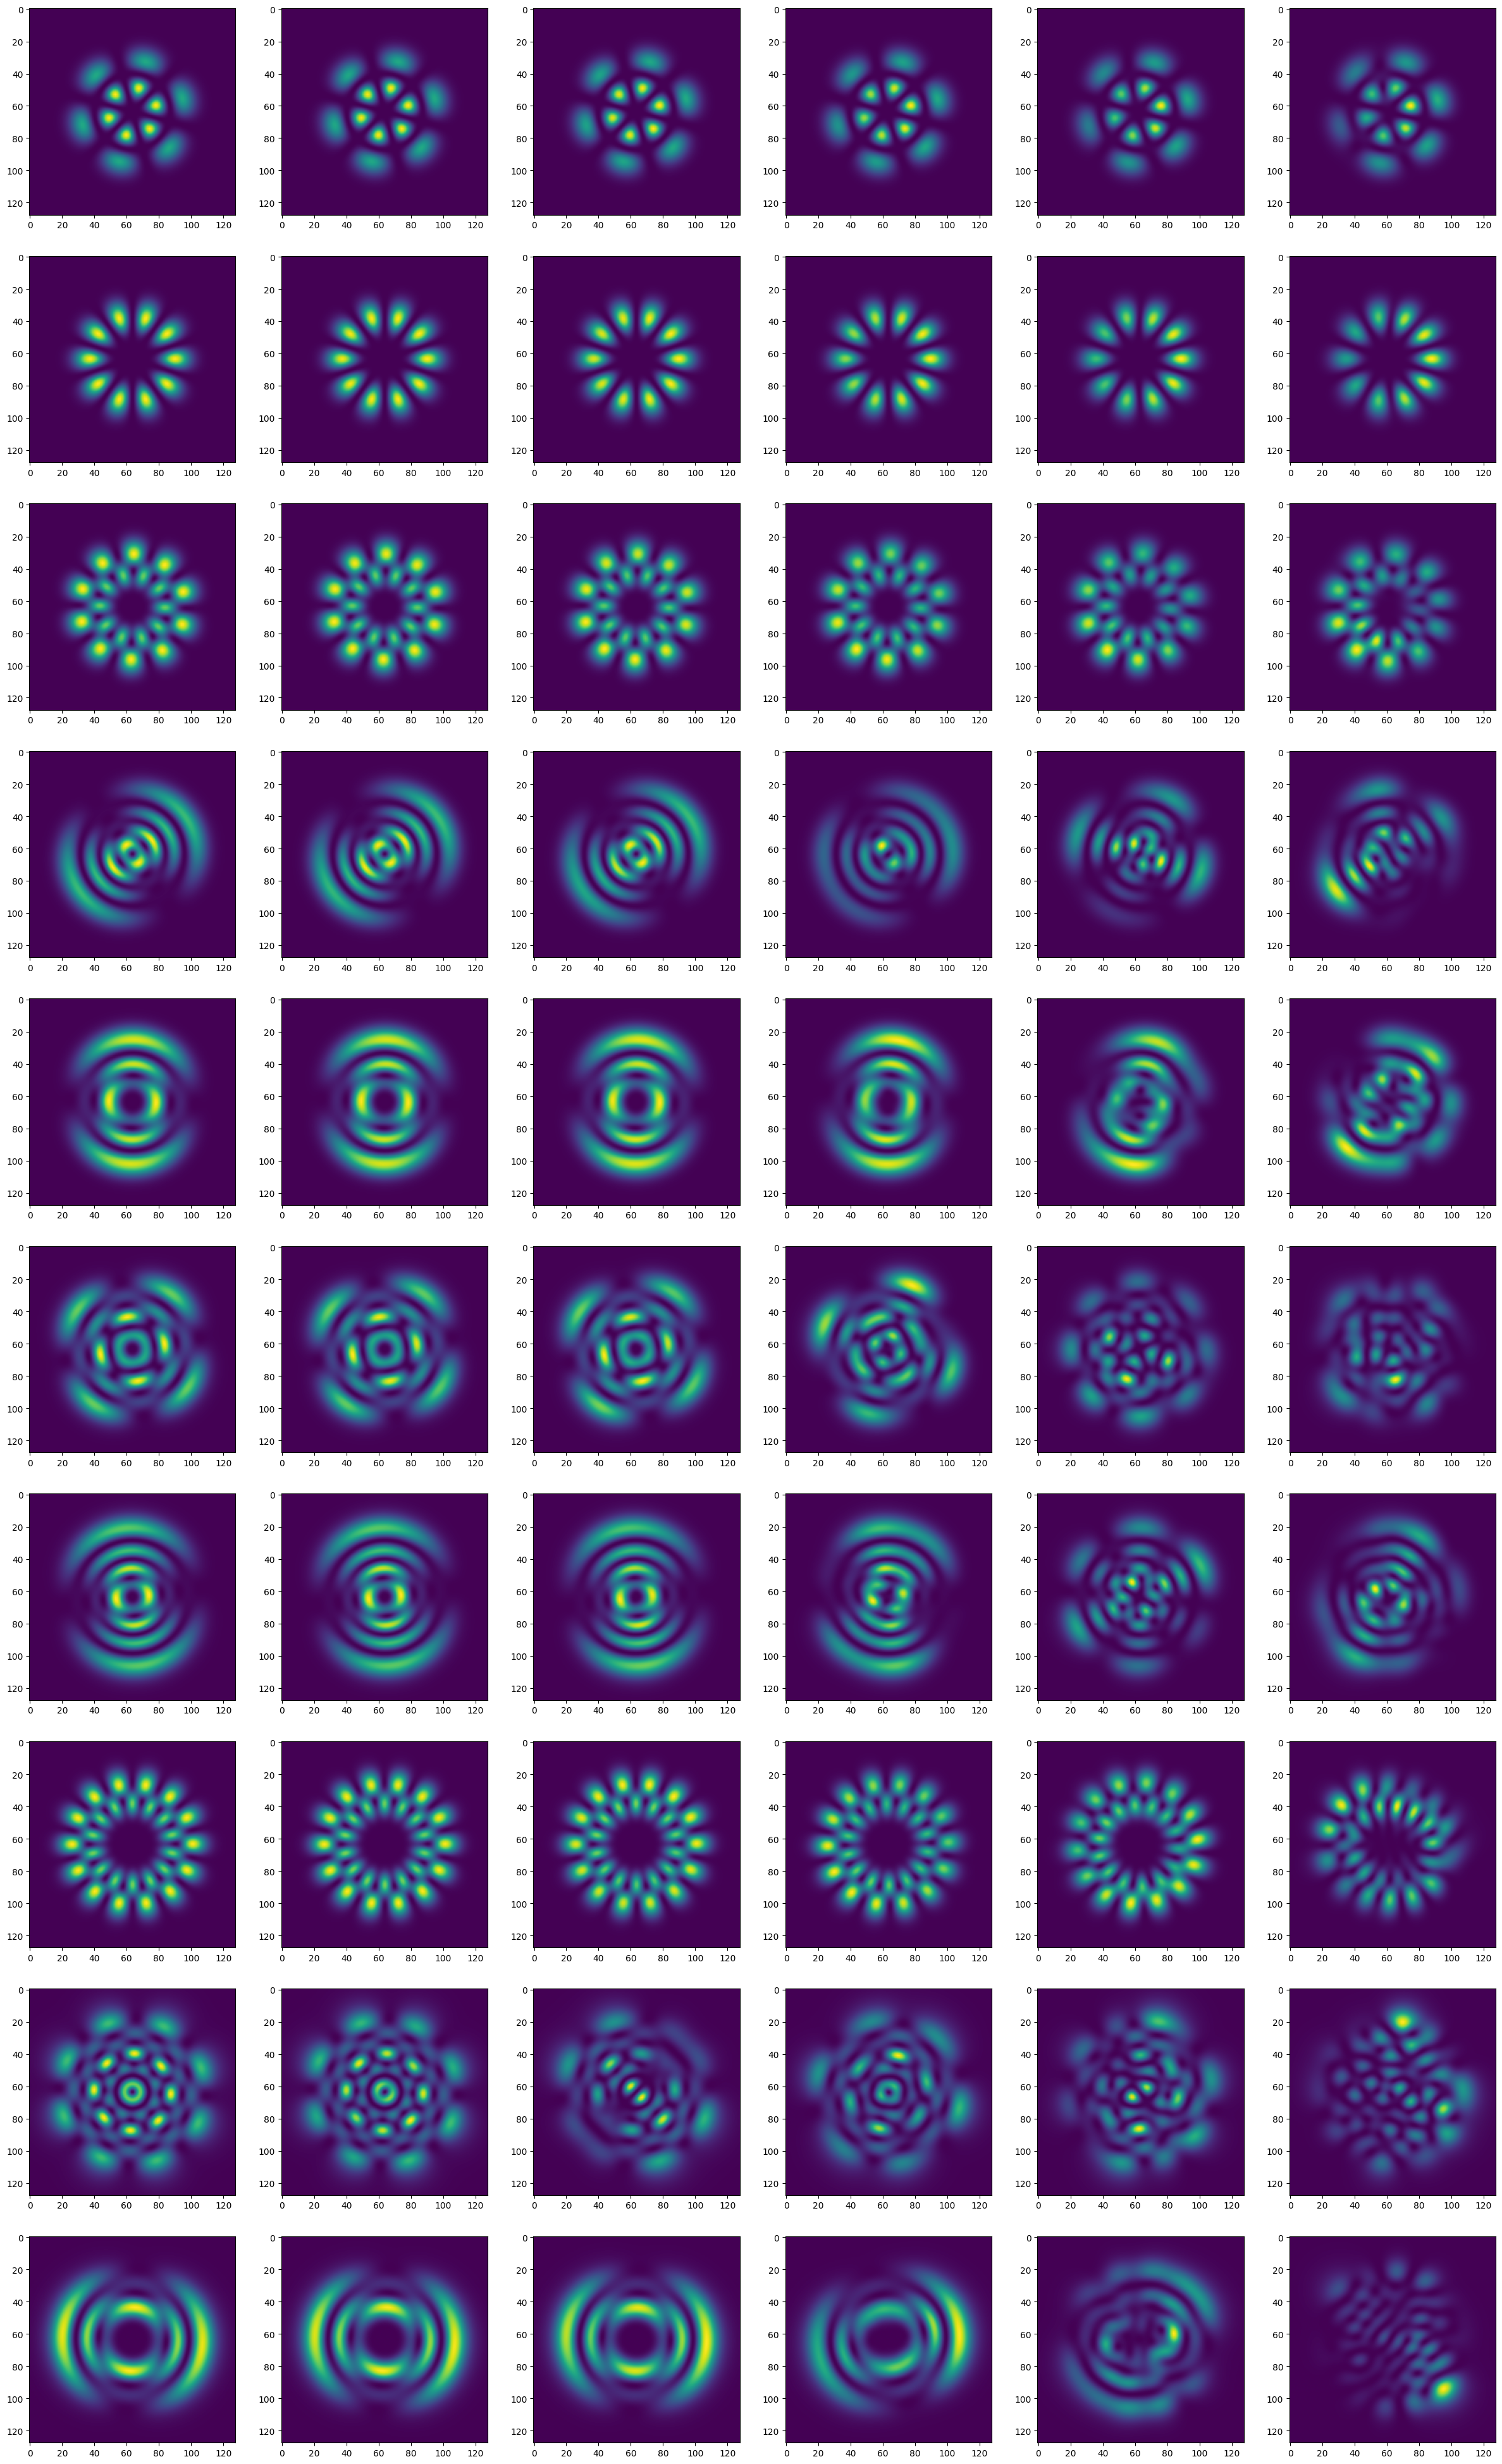

In [31]:
fig, ax = plt.subplots(len(modes_numbers), len(curvatures), figsize=(len(curvatures)*5, len(modes_numbers)*5))

for img_idx, mode_idx in enumerate(modes_numbers):
    for img_idx_curvature, curvature in enumerate(curvatures):
        ax[img_idx, img_idx_curvature].imshow(total_curved_intensities[img_idx_curvature][mode_idx].reshape((128, 128)))

fig.savefig('modes when bending.png')

А теперь датасет для обучения, в котором волокна случайно гнутся. Радиус кривизны -- от бесконечности до 3 см
Направление изгиба -- равномерное распределение от 0 до $2\pi$
Радиус изгиба: $ r^{-1} \propto w[0; 3 cm^{-1}] $


np.random.rand[num_samples, r_x, r_y]

## Класс для создания датасета со случайно изогнутыми волокнами, генерация датасета и обучение модели.

В этом датасете генерируются данные для нескольких различных радиусоов кривизны волокна. Можно считать, что добавлена аугментация в виде искривления паттернов (см пример на картинке с принтом для футболки) при случайно выбранной кривизне волокна

In [32]:
from tqdm import tqdm

class BentFGI_MNIST(Dataset):
    def __init__(self, mnist_dataset, modes, modes_info, min_r_curvature,
                 num_benders, fgi_vec_transform=None, 
                 task="classification", distance=300.0e3):
        super().__init__()

        # MNIST part
        self.img_size = len(mnist_dataset.data[0])
        self.mnist_images = mnist_dataset.data
        self.target_labels = mnist_dataset.targets
        mnist_transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                              transforms.Normalize(0, 0.5),
                                              nn.Flatten()])
        
        if task=='classification':
            self.y = self.target_labels
        elif task=='image_restoration':
            self.y = self.target_images
        else:
            raise TypeError("Can't create dataset because the type of task is invalid")

        self.target_images = mnist_transform(self.mnist_images)

        # Fiber part
        patterns_transform = transforms.Compose([
                                            transforms.Resize(self.img_size),
                                            transforms.ConvertImageDtype(torch.float32),
                                            transforms.Normalize(0, 0.5),
                                            nn.Flatten()])
        self.modes = modes
        self.modes_info = modes_info
        self.min_r_curvature = min_r_curvature
        self.distance = distance
        self.num_benders = num_benders

        # may be applied, for example, for adding photocount noise
        self.fgi_vec_transform = fgi_vec_transform

        self.rands = np.random.rand(num_benders, 2)
        self.bent_intensities = []
        for rand_curvature in tqdm(self.rands, desc='Calculating bent modes'):
            r = self.min_r_curvature / rand_curvature[0]
            phi = 2 * np.pi * rand_curvature[1]
            bender = Bender(modes, [r/np.cos(phi), r/np.sin(phi)],
                            self.distance)
            intensities = patterns_transform( 
                torch.Tensor(bender.getIntensityProfilesCurved(self.modes_info)) )
            
            if self.fgi_vec_transform is not None:
                intensities = self.fgi_vec_transform(intensities)

            self.bent_intensities.append(intensities)

    def __len__(self):
        return len(self.target_labels)

    def __getitem__(self, idx):
        bent_patterns_idx = np.random.randint(0, self.num_benders)
        fgi_vector = torch.matmul(self.target_images[idx],
                                   self.bent_intensities[bent_patterns_idx].T)
        return fgi_vector, self.y[idx]


In [33]:
fgi_test_bent_dataset = BentFGI_MNIST(mnist_test, modes, intensities.getModesInfo(),
                                      3*cm, 10,
                                   task='classification')

fgi_train__bentdataset = BentFGI_MNIST(mnist, modes, 
                                    intensities.getModesInfo(),
                                    3*cm, 100,
                                   task='classification')

Calculating bent modes: 100%|██████████| 100/100 [14:22<00:00,  8.62s/it]


In [34]:
train_loader = DataLoader(fgi_train__bentdataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(fgi_test_bent_dataset, batch_size=256, shuffle=False, num_workers=2)


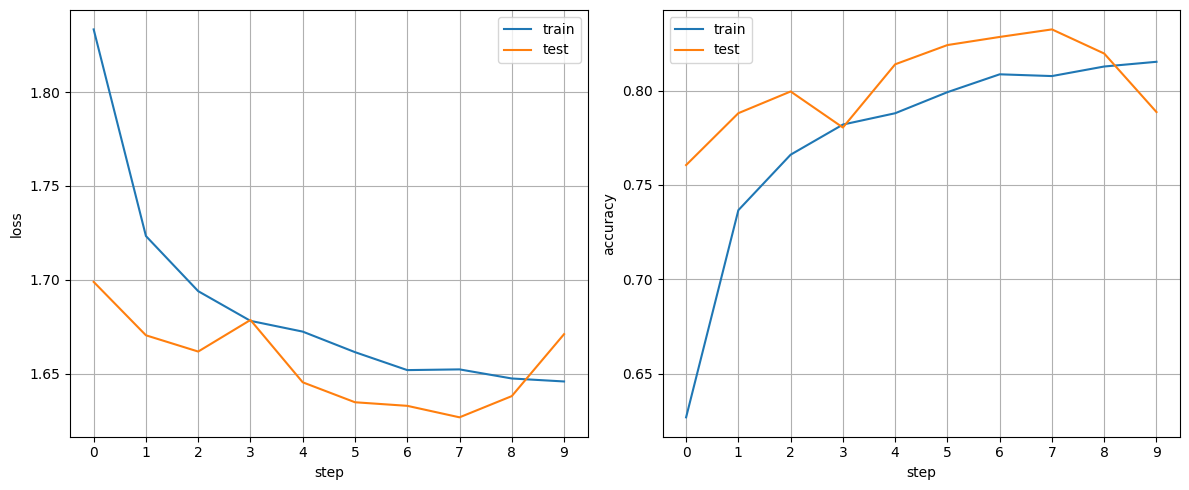

In [35]:
set_random_seed(42)
model = SimpleFGIClassifier(len(intensities.getIntensityProfiles())).to(device)  # Create model instance
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model, criterion, optimizer, num_epochs=10, device=device)

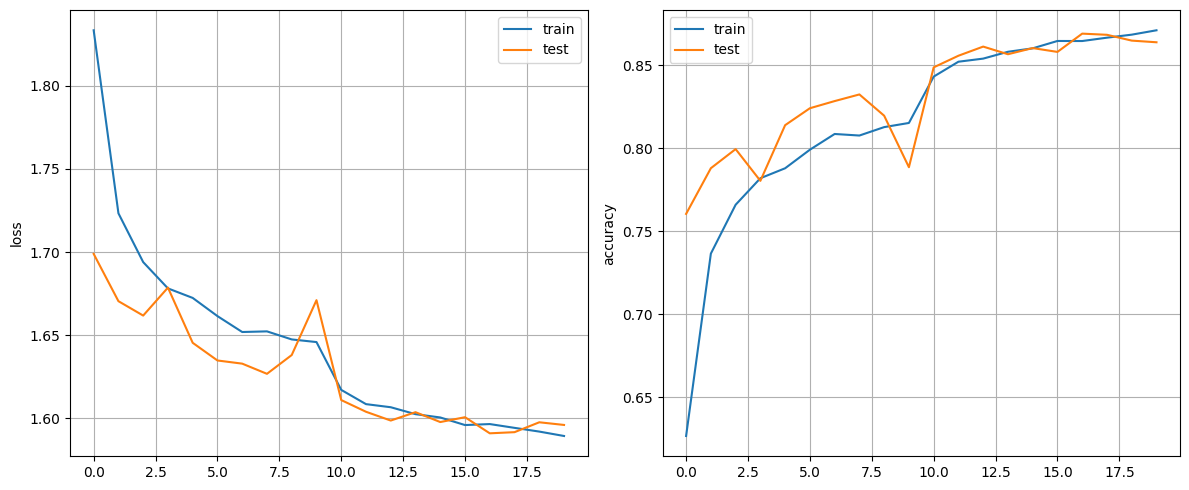

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
pp = train(model, criterion, optimizer, num_epochs=10, device=device, pp=pp)

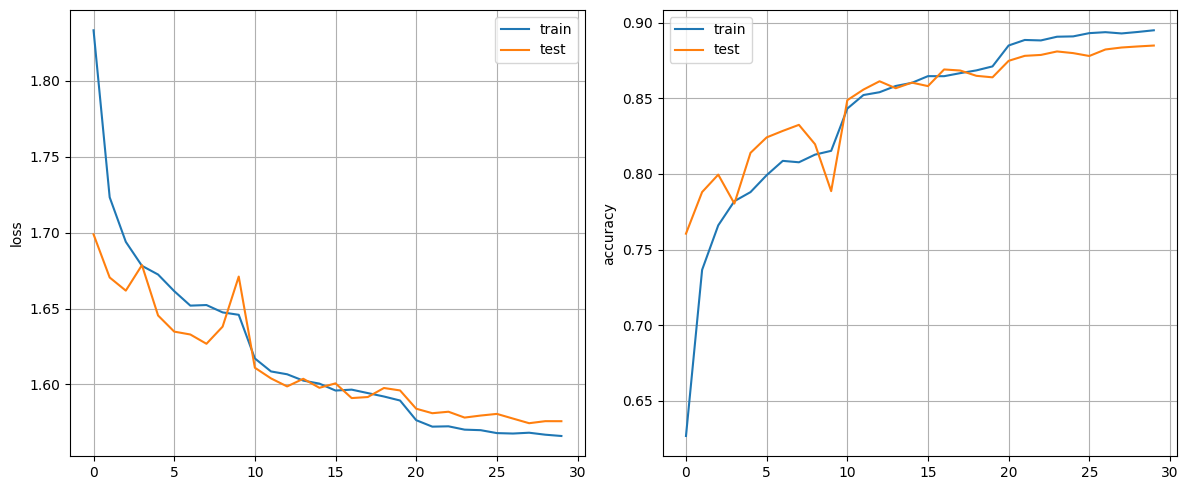

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
pp = train(model, criterion, optimizer, num_epochs=10, device=device, pp=pp)

## Сравнение точности моделей, обученных на двух датасетах

In [38]:
cm = 1.0e4 # 1 cm in microns
curvatures = [np.inf, 100*cm, 30*cm, 10*cm, 5*cm, 3*cm]

# curved fiber along x-axis
accuracies_curved_x = []
for radius in curvatures:
    bender_curved = Bender(modes, [radius, np.inf], 300.0e3)
    intensities_curved = bender_curved.getIntensityProfilesCurved(intensities.getModesInfo())
    fgi_test_dataset_curved = SimpleFGI_MNIST(mnist_test, 
                                   torch.Tensor(intensities_curved),
                                   task='classification')
    test_loader_curved = DataLoader(fgi_test_dataset_curved, batch_size=256, shuffle=False, num_workers=2)
    accuracies_curved_x.append(calaculate_accuracy(model, test_loader_curved, criterion, device)[0])

In [39]:
accuracy_new = np.array(accuracies_curved_x)
curvatures_arr = np.array(curvatures)

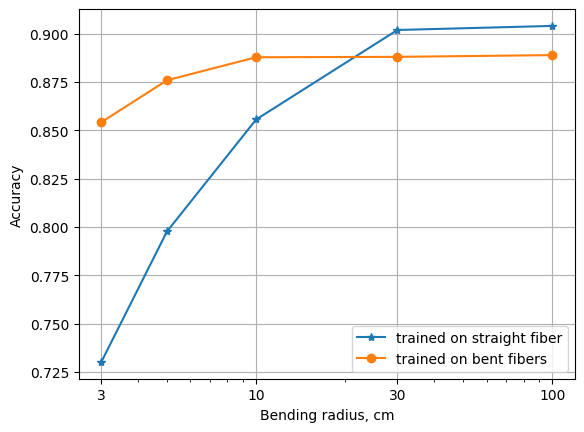

In [40]:

import matplotlib.pyplot as plt

horiz_line = [accuracy[0]] * (len(accuracy)-1)

plt.xscale('log')
plt.grid()
plt.xlabel('Bending radius, cm')
plt.ylabel('Accuracy')
plt.xticks([3, 10, 30, 100], [3, 10, 30, 100])

#plt.plot(curvatures_arr[1:]/cm, horiz_line, label='direct fiber')
plt.plot(curvatures_arr[1:]/cm, accuracy[1:], '*-', label='trained on straight fiber')
plt.plot(curvatures_arr[1:]/cm, accuracy_new[1:], 'o-', 
         label='trained on bent fibers')
plt.legend()
plt.savefig('accuracy_fibers_both')
plt.show()